# Analysis of Forced Isotropic Flow

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Loading the data

In [7]:
%%time
cols = arange(15)
f = open('data/Iso_turb_box512adjacent.csv', 'r')
colstuple = np.loadtxt(f, delimiter=',', usecols=cols, unpack=True )

CPU times: user 21min 39s, sys: 12.9 s, total: 21min 52s
Wall time: 21min 54s


In [8]:
colstuple.shape

(15, 134217728)

#### Unpacking after loading

In [9]:
x = colstuple[0]
y = colstuple[1]
z = colstuple[2]
v_x = colstuple[3]
v_y = colstuple[4]
v_z = colstuple[5]
d_ux_dx = colstuple[6]
d_ux_dy = colstuple[7]
d_ux_dz = colstuple[8]
d_uy_dx = colstuple[9]
d_uy_dy = colstuple[10]
d_uy_dz = colstuple[11]
d_uz_dx = colstuple[12]
d_uz_dy = colstuple[13]
d_uz_dz = colstuple[14]

In [10]:
def packing_to_3d(array_1d, L):
    array_3d = empty( (L, L, L), dtype=float )
    for i in range(L):
        for j in range(L):
            for k in range(L):
                array_3d[i,j,k] = array_1d[ k + L*( j + L*i ) ]
    return array_3d

In [11]:
xnodes = unique( x )
ynodes = unique( y )
znodes = unique( z )

In [12]:
xnodes[::8]

array([0.        , 0.04908739, 0.09817477, 0.14726216, 0.19634955,
       0.24543694, 0.2945243 , 0.34361172, 0.3926991 , 0.44178647,
       0.49087387, 0.5399613 , 0.5890486 , 0.638136  , 0.68722343,
       0.7363108 , 0.7853982 , 0.8344856 , 0.88357294, 0.93266034,
       0.98174775, 1.0308352 , 1.0799226 , 1.1290098 , 1.1780972 ,
       1.2271847 , 1.276272  , 1.3253595 , 1.3744469 , 1.4235342 ,
       1.4726216 , 1.521709  , 1.5707964 , 1.6198838 , 1.6689712 ,
       1.7180586 , 1.7671459 , 1.8162333 , 1.8653207 , 1.9144081 ,
       1.9634955 , 2.0125828 , 2.0616703 , 2.1107576 , 2.159845  ,
       2.2089324 , 2.2580197 , 2.3071072 , 2.3561945 , 2.405282  ,
       2.4543693 , 2.5034568 , 2.552544  , 2.6016314 , 2.650719  ,
       2.6998062 , 2.7488937 , 2.797981  , 2.8470683 , 2.8961558 ,
       2.9452431 , 2.9943306 , 3.043418  , 3.0925055 ])

In [13]:
L = xnodes.shape[0]
L

512

In [14]:
X, Y, Z = meshgrid(xnodes, ynodes, znodes, indexing = 'ij')

#### All points in a flattened array

In [15]:
%%time
points = np.array(list(itertools.product(xnodes, ynodes, znodes ) ) ) 

CPU times: user 55.3 s, sys: 4.63 s, total: 59.9 s
Wall time: 59.7 s


### Calculating and saving important quantities

#### Rotation of the velocity field (angular speed)

$\omega = \nabla \times u$

#### Enstrophy: $S = \frac{1}{2} \omega^2$

In [16]:
%%time
Enstrophy = packing_to_3d( 0.5*( ( d_uz_dy - d_uy_dz )**2 + 
                                 ( d_ux_dz - d_uz_dx )**2 + 
                                 ( d_uy_dx - d_ux_dy )**2 ), L )

CPU times: user 43.8 s, sys: 1.52 s, total: 45.3 s
Wall time: 45.4 s


#### Energy: $E = \frac{1}{2}v^2$

In [17]:
%%time
Energy = packing_to_3d( 0.5*( v_x**2 + v_y**2 + v_z**2 ), L )

CPU times: user 42.3 s, sys: 1.39 s, total: 43.7 s
Wall time: 43.7 s


#### Dissipation: 

$S^2 = S_{ij} S_{ij}$, where $S_{ij} = \frac{1}{2} (\nabla u + \nabla u^T)_{ij}$

Q, R are other two scalar invariants of the velocity gradient tensor

#### This is calculated by a 3x3 matrix at each node (!)

In [18]:
vel_grad_at_points = colstuple[6:].T
vel_grad_at_points.shape

(134217728, 9)

In [19]:
%%time
V_grad_matrix = empty( (3,3), dtype=float )
S_ij = empty( (3,3), dtype=float )
S_square = empty( x.shape[0], dtype=float )
for k in range( x.shape[0] ):
    V_grad_matrix[0,0] = vel_grad_at_points[k,0]
    V_grad_matrix[0,1] = vel_grad_at_points[k,3]
    V_grad_matrix[0,2] = vel_grad_at_points[k,6]
    V_grad_matrix[1,0] = vel_grad_at_points[k,1]
    V_grad_matrix[1,1] = vel_grad_at_points[k,4]
    V_grad_matrix[1,2] = vel_grad_at_points[k,7]
    V_grad_matrix[2,0] = vel_grad_at_points[k,2]
    V_grad_matrix[2,1] = vel_grad_at_points[k,5]
    V_grad_matrix[2,2] = vel_grad_at_points[k,8]

    S_ij = 0.5*( V_grad_matrix + V_grad_matrix.T )
    S_square[k] = sum( S_ij**2 )

CPU times: user 19min 46s, sys: 1.66 s, total: 19min 48s
Wall time: 19min 48s


### Requesting data for excursion sets

Excursion set indicator function for a scalar field $A(x)$:

$ \Theta^A_\chi (x) = H(A(x)-\chi) = 
\begin{cases}
1, ~if ~A(x) \geq \chi \\
0, ~otherwise
\end{cases}$

Excursion set for the enstrophy for the threshold $\chi = 20 \langle S^2 \rangle$:

$E_{\chi} (x) = E (x) \Theta^{E}_\chi (x) = E (x) \Theta^{E}_{20 \langle S^2 \rangle} (x) = 
\begin{cases}
E(x), ~if ~E(x) \geq 20 \langle S^2 \rangle \\
0, ~otherwise
\end{cases}$

#### In theory: $\langle S^2 \rangle = \frac{1}{2} \langle \omega^2 \rangle$ for isotropic turbulent flow.
Let's check:

In [20]:
mean(S_square), mean(Enstrophy)

(229.89721393126678, 229.53502837035703)

In [21]:
%%time
S_square = packing_to_3d( S_square, L )

CPU times: user 34.5 s, sys: 312 ms, total: 34.8 s
Wall time: 34.8 s


In [22]:
Energy.shape, Enstrophy.shape, S_square.shape

((512, 512, 512), (512, 512, 512), (512, 512, 512))

In [23]:
mean_ens = mean(Enstrophy)

In [24]:
mean_diss = mean(S_square)

### Calculating correlation for excursion sets

In [25]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy) # elevation - theta
    az = np.arctan2(y, x) # azimuth - phi
    return r, el, az

In [26]:
kolm = 0.00280

In [27]:
def simple_integrator(y, x):
    no_points = len(x)
    if (no_points == 1):
        return y[0] * pi * 0.5
    else:
        differences = np.diff(x)
        if (x[0] != 0):
            differences = insert(differences, 0, x[0])
            return ( np.sum(differences * y) )
        else:
            return ( np.sum(differences * y[:-1]) + (pi/2 - x[-1]) * y[-1] )

In [28]:
def correl_angular_integrator_simple(interval_lower_index, interval_upper_index, 
                              points_sphere_r_sorted, func_val_r_sorted):
    distance = mean( points_sphere_r_sorted[interval_lower_index : interval_upper_index, 0] )
    surface = points_sphere_r_sorted[interval_lower_index : interval_upper_index, 1:]
    values = func_val_r_sorted[interval_lower_index : interval_upper_index]
    
    surface_sort = lexsort( ( surface[:,1], surface[:,0] ) )
    S = surface[ surface_sort ]
    V = values[ surface_sort ]
    
    diff_theta = np.diff( S[:,0] )
    bounds = argwhere( [ not i for i in isclose( diff_theta, 0, atol=1e-6 )  ] )
    true_bounds = bounds.reshape( bounds.shape[0] )+1
    true_bounds = insert( true_bounds, 0, 0 )
    true_bounds = insert( true_bounds, true_bounds.shape[0], S.shape[0] )
    theta_values = S[true_bounds[:-1],0] # theta 
    
    phi_list = []
    Cr_list = []
    for i in range( true_bounds.shape[0]-1 ):
        upper_limit = true_bounds[i+1]
        lower_limit = true_bounds[i]

        phi_list.append( S[lower_limit:upper_limit, 1] )
        Cr_list.append( V[lower_limit:upper_limit] )
        
    phi_int = zeros( len(phi_list) )
    for i in range( len(phi_list) ):
        phi_int[i] = simple_integrator( Cr_list[i], phi_list[i] )
        
    integrand = np.sin( theta_values ) * phi_int
    return (simple_integrator( integrand, theta_values ) ), (distance)

In [29]:
def linfit( x, a, b ):
    return a*x+b

### Excursion sets for thresholds in mean(diss) units

In [30]:
def excursion(quantity, limit, points):
    threshold = limit * mean_diss
    indices = argwhere( quantity > threshold )
    theta = zeros( X.shape, dtype=int )
    for i in range( indices.shape[0] ):
        theta[ indices[i,0], indices[i,1], indices[i,2] ] = 1
        
    abs_theta_k = np.abs( fft.rfftn( theta, axes=(0,1,2), norm="ortho" ) )**2
    Cr = fft.irfftn( abs_theta_k, axes=(0,1,2), norm="ortho" )
    
    Cr_points = Cr.flatten()
    
    points_sphere = empty( points.shape, dtype=float )
    for i in range( points.shape[0] ):
        points_sphere[i] = cart2sph( *points[i] )
    
    sort_idx = lexsort( (points_sphere[:,2], points_sphere[:,1], points_sphere[:,0]) )
    points_sphere_r_sorted = points_sphere[ sort_idx ]
    Cr_r_sorted = Cr_points[ sort_idx ]
    
    diff_between_radii = np.diff(points_sphere_r_sorted[:,0])
    boundaries = argwhere( [ not i for i in isclose( diff_between_radii, 0, atol=1e-5 ) ] )
    true_boundaries = boundaries.reshape( boundaries.shape[0] )+1
    print('Boundaries:', true_boundaries.shape[0])
    
    correlation_normed = zeros(len(true_boundaries)-1)
    r_values = zeros(len(true_boundaries)-1)
    for i in range( true_boundaries.shape[0]-1 ):
        upper_limit = true_boundaries[i+1]
        lower_limit = true_boundaries[i]

        correl, dist = correl_angular_integrator_simple(lower_limit, upper_limit, points_sphere_r_sorted, Cr_r_sorted)
        correlation_normed[i] = correl/Cr[0,0,0]
        r_values[i] = dist/kolm
        
    r_values = insert( r_values, 0, 0 )
    correlation_normed = insert( correlation_normed, 0, 1 )
    
    filt = np.logical_and( r_values !=0, correlation_normed != 0 )
    filt2 = np.logical_and( correlation_normed > 0, filt )
    log_r_values = log10( r_values[ filt2 ] )
    log_correlation_normed = log10( correlation_normed[ filt2 ] )
    
    return r_values, correlation_normed, log_r_values, log_correlation_normed

In [31]:
def integrate_and_save( quantity, limits, filename, points ):
    """Excursion set can be S_square or Energy, limits is a list of thresholds"""
    for n in limits:
        print('Turn:', n)
        r_values, correlation_normed, log_r_values, log_correlation_normed = excursion(quantity, n, points)
        
        file = open( filename+'_normal_'+str(n)+'.txt', 'w' ) # create file to write out
        file.write("#r_values\tcorrelation_normed\n")

        for i in range( len(r_values) ):
            file.write( "%f %f\n" % (r_values[i], correlation_normed[i] ) )
        file.close()
        
        file = open( filename+'_log_'+str(n)+'.txt', 'w' ) # create file to write out
        file.write("#log_r_values\tlog_correlation_normed\n")

        for j in range( len(log_r_values) ):
            file.write( "%f %f\n" % (log_r_values[j], log_correlation_normed[j]) )
        file.close()

In [32]:
S_square.shape, Energy.shape

((512, 512, 512), (512, 512, 512))

In [33]:
a = [7, 10, 15, 20, 30, 50]

In [39]:
%%time
integrate_and_save( S_square, a[5:6], 'Dissipation', points )

Turn: 50
Boundaries: 135444
CPU times: user 37min 58s, sys: 11.9 s, total: 38min 10s
Wall time: 38min 10s


In [41]:
%%time
integrate_and_save( Enstrophy, a[1:], 'Enstrophy', points )

Turn: 10
Boundaries: 135444
Turn: 15
Boundaries: 135444
Turn: 20
Boundaries: 135444
Turn: 30
Boundaries: 135444
Turn: 50
Boundaries: 135444
CPU times: user 2h 53min 29s, sys: 53.6 s, total: 2h 54min 23s
Wall time: 2h 54min 25s


#### Code for creating plots with linear fit

In [222]:
"""def final_corr_plot_and_fit( log_r_values, log_correlation_normed, lower, upper, rounding=4, t1=-3.5, t2=0, out=0.5, figname="" ):
    a = np.logical_and( log_r_values > lower, log_r_values < upper )
    inliers_ind = log_correlation_normed > np.mean( log_correlation_normed ) + out*np.std( log_correlation_normed )
    b = np.logical_and( a, inliers_ind )
    
    cutoff_idx = int(0.01*len(log_r_values))
    
    popt, pcov = curve_fit( linfit, log_r_values[b][:cutoff_idx], log_correlation_normed[b][:cutoff_idx] )
    print("Decaying frequency exponent: %.3f +/- %.3f" % (popt[0], np.sqrt(pcov[0,0])))
    
    exponent = popt[0]
    error = np.sqrt(pcov[0,0])
    
    plt.figure( figsize=(8,3), dpi=100 )
    #plt.loglog( r_values, correlation_normed, '.')
    plt.tick_params( axis='both', which='major', labelsize=12 )
    xlabel('$ \log_{10} \left( \\frac{r}{\eta} \\right) $', fontsize=16)
    ylabel('$ \log_{10} C(r) $', fontsize=16)
    plt.scatter( log_r_values[:cutoff_idx], log_correlation_normed[:cutoff_idx], s=10, marker='o' )
    plt.plot( log_r_values[a], popt[0]*log_r_values[a]+popt[1], '-', c='r', 
             label='Exponent: '+str(round(popt[0], rounding) )+'+/-'+str( round( sqrt(pcov[0,0]) , rounding) ) )
    plt.legend( fontsize=12 )
    plt.ylim([t1, t2])
    plt.subplots_adjust(bottom=0.25)
    plt.title('$S^2$, $\chi = '+figname[-2:]+'\langle S^2 \\rangle$', fontsize = 18)
    #plt.title('$\\frac{1}{2}\omega^2$, $\chi = '+figname[-2:]+'\langle S^2 \\rangle$', fontsize = 18, pad=7)
    plt.savefig( "ens_"+figname+".png", dpi=100 )

    return exponent, error"""

Decaying frequency exponent: -2.934 +/- 0.242


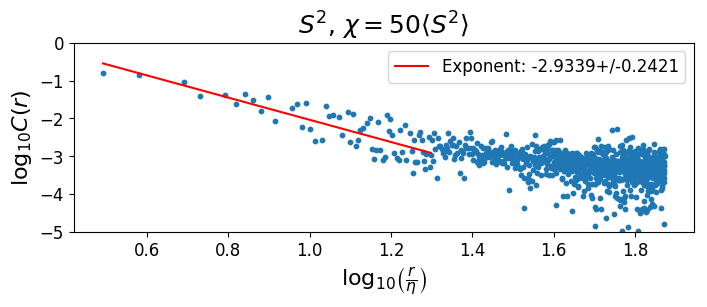

In [236]:
"""f1 = open('Dissipation_log_50.txt', 'r')
log_r, log_corr = np.loadtxt(f1, delimiter=' ', usecols=(0, 1), unpack=True)
exp, err = final_corr_plot_and_fit( log_r, log_corr, lower=0.3, upper=1.3, rounding=4, t1=-5, figname="small_50" )"""

### Energy spectrum

In [42]:
dx = xnodes[1]-xnodes[0]
dy = ynodes[1]-ynodes[0]
dz = znodes[1]-znodes[0]
dx, dy, dz

(0.0061359233, 0.0061359233, 0.0061359233)

In [43]:
lx = L*dx
ly = L*dy
lz = L*dz

In [44]:
dkx = 2*pi / lx
dky = 2*pi / ly
dkz = 2*pi / lz

In [45]:
kx_max = pi / dx
ky_max = pi / dy
kz_max = pi / dz

In [46]:
dx, lx, dkx, kx_max

(0.0061359233, 3.1415927296, 1.9999999516104006, 511.99998761226254)

In [47]:
kx = np.fft.fftfreq(L, d = dx)*2*pi
kx.shape#, kx[:int(L/2)]

(512,)

In [48]:
ky = kx
kz = kx

In [49]:
%%time
# perform 3 dimensional FFT:
Energy_k = np.abs( np.fft.fftn( Energy-mean(Energy), axes=(0,1,2), norm="ortho" ) )
Energy_k.shape, Energy_k[0,0,0] # two sided spectrum in each direction

CPU times: user 10.1 s, sys: 2.79 s, total: 12.9 s
Wall time: 12.9 s


#### Calculate the energy spectrum from the first half of the two-sided spectrum with k at zero

##### Generating all points

In [50]:
kx_new = kx[:int(L/2)]
ky_new = ky[:int(L/2)]
kz_new = kz[:int(L/2)]

In [51]:
%%time
kpoints = np.array(list(itertools.product(kx_new, ky_new, kz_new ) ) ) 

CPU times: user 5.78 s, sys: 560 ms, total: 6.34 s
Wall time: 6.77 s


##### Converting to spherical 

In [52]:
%%time
kpoints_sphere = empty( kpoints.shape, dtype=float )
for i in range( kpoints.shape[0] ):
    kpoints_sphere[i] = cart2sph( *kpoints[i] )
kpoints_sphere.shape

CPU times: user 2min, sys: 120 ms, total: 2min
Wall time: 2min


In [53]:
E_d_new = Energy_k[:int(L/2),:int(L/2),:int(L/2)] # speratating the first half of the spectrum
E_d_new.shape

(256, 256, 256)

In [54]:
%%time
# sorting indices for the coordinates, sort EVERY column, but radius is the primary
ksort_idx = lexsort( (kpoints_sphere[:,2], kpoints_sphere[:,1], kpoints_sphere[:,0]) )
ksort_idx

CPU times: user 5.15 s, sys: 164 ms, total: 5.32 s
Wall time: 5.32 s


In [55]:
E_d_points = E_d_new.flatten()
kpoints_sphere_r_sorted = kpoints_sphere[ ksort_idx ]
E_d_r_sorted = E_d_points[ ksort_idx ]

In [56]:
E_d_r_sorted.shape, kpoints_sphere_r_sorted.shape

((16777216,), (16777216, 3))

In [57]:
kdiff_between_radii = np.diff(kpoints_sphere_r_sorted[:,0])
kboundaries = argwhere( [ not i for i in isclose( kdiff_between_radii, 0, atol=1e-5 ) ] )
kboundaries.shape

(139637, 1)

In [58]:
ktrue_boundaries = kboundaries.reshape( kboundaries.shape[0] )+1
ktrue_boundaries[:10]

array([ 1,  4,  7,  8, 11, 17, 20, 23, 29, 35])

In [59]:
%%time
E_k = zeros(len(ktrue_boundaries)-1)
k_values = zeros(len(ktrue_boundaries)-1)
for i in range( ktrue_boundaries.shape[0]-1 ):
    upper_limit = ktrue_boundaries[i+1]
    lower_limit = ktrue_boundaries[i]
    
    energy, dist = correl_angular_integrator_simple( lower_limit, upper_limit, 
                                                    kpoints_sphere_r_sorted, E_d_r_sorted )
    E_k[i] = energy
    k_values[i] = dist

CPU times: user 2min 40s, sys: 8.07 ms, total: 2min 40s
Wall time: 2min 40s


Text(0,0.5,'E(k)')

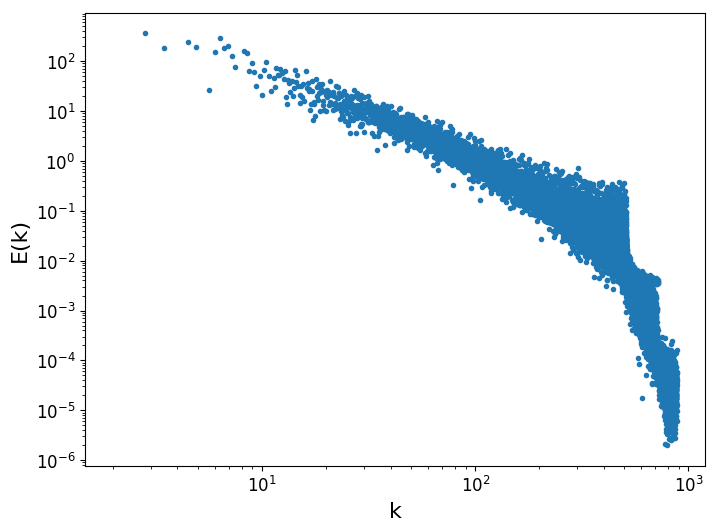

In [60]:
plt.figure( figsize=(8,6), dpi=100 )
plt.loglog( k_values, E_k, '.')
plt.tick_params( axis='both', which='major', labelsize=12 )
xlabel('k', fontsize=16)
ylabel('E(k)', fontsize=16)
# plt.savefig( 'E_k_loglog_pure_whole.png', dpi=100 )

#### Writing output to file

In [61]:
file = open( 'Energy_spectrum.txt', 'w' ) # create file to write out
file.write("#k_values\tE_k_radial\n")

for i in range( len(k_values) ):
    file.write( "%f %f\n" % (k_values[i], E_k[i]) )
file.close()

#### Code for creating plot with linear fit

In [62]:
"""f1 = open('Dissipation_log_7.txt', 'r')
log_k_values, log_E_k = np.loadtxt(f1, delimiter=' ', usecols=(0, 1), unpack=True)"""

"f1 = open('Dissipation_log_7.txt', 'r')\nlog_k_values, log_E_k = np.loadtxt(f1, delimiter=' ', usecols=(0, 1), unpack=True)"

In [66]:
filt = np.logical_and( k_values !=0, E_k != 0 )
filt2 = np.logical_and( E_k > 0, filt )
log_k_values = log10( k_values[ filt2 ] )
log_E_k = log10( E_k[ filt2 ] )

In [244]:
def linfit( x, a, b ):
    return a*x+b

cutoff_idx = int(0.05*len(log_k_values))

# fitting
b = np.logical_and( log_k_values > 0.3, log_k_values < 1.9 )
log_k_values[b].shape, log_E_k[b].shape
popt, pcov = curve_fit( linfit, log_k_values[b][:cutoff_idx], log_E_k[b][:cutoff_idx] )

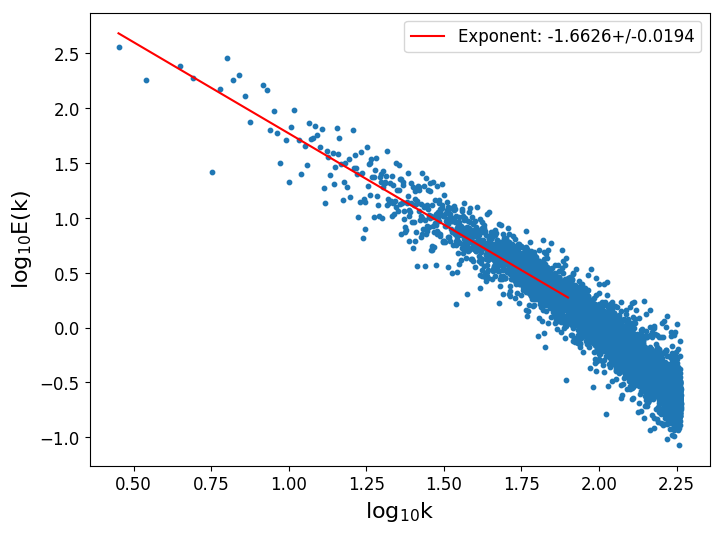

In [245]:
plt.figure( figsize=(8,6), dpi=100 )
plt.tick_params( axis='both', which='major', labelsize=12 )
xlabel('log$_{10}$k', fontsize=16)
ylabel('log$_{10}$E(k)', fontsize=16)
plt.scatter( log_k_values[:cutoff_idx], log_E_k[:cutoff_idx], s=10, marker='o' )
plt.plot( log_k_values[b], popt[0]*log_k_values[b]+popt[1], '-', c='r', 
         label='Exponent: '+str(round(popt[0], 4) )+'+/-'+str( round( sqrt(pcov[0,0]) , 4) ) )
plt.legend( fontsize=12 )
plt.savefig( 'Ek_loglog_linfit_512adjacent.png', dpi=100 )